In [14]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
#import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split





#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [35]:
toxic_x_test = pd.read_csv('test.csv',index_col='id')
toxic_y_test=pd.read_csv('test_labels.csv',index_col='id')
toxic_test=toxic_x_test.join(toxic_y_test, on='id')
toxic_test.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [16]:
toxic_train = pd.read_csv('train.csv',index_col='id')
toxic_train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [17]:
nrow_train=toxic_train.shape[0]
nrow_test=toxic_test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


It seems that the train data is almost the same size as the test data

# Check for duplicate and null values

In [18]:
toxic_train[toxic_train.duplicated('comment_text')]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,


In [19]:
toxic_train.isnull().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

# Exploratory Data Analysis

Add the clean column

In [44]:
x=toxic_train.iloc[:,1:-1].sum()
#marking comments without any tags as "clean"
rowsums=toxic_train.iloc[:,1:-1].sum(axis=1)
toxic_train['clean']=(rowsums==0)
#count number of clean entries
toxic_train['clean'].sum()
print("Total comments = ",len(toxic_train))
print("Total clean comments = ",toxic_train['clean'].sum())
print("Total tags =",x.sum())
toxic_train.head()

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,length
id,,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True,264
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True,112
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True,233
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True,622
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True,67


Add length of the comment to analyze

In [21]:
toxic_train['length'] = toxic_train['comment_text'].apply(len)
toxic_train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,length
id,,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True,264
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True,112
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True,233
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True,622
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True,67


## Data Validation

In [22]:
toxic_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,length
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,394.073221
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,590.720282
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,96.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,205.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,435.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5000.000000


It seems like the data is imbalanced

## Data Visualization

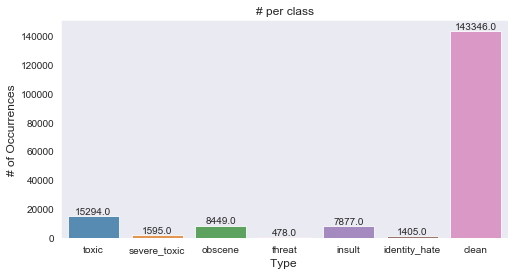

In [23]:
x=toxic_train.iloc[:,1:-1].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## Example Comments:
Let's see the example of each comment to get better understanding

In [24]:
print("toxic:")
print(toxic_train[toxic_train.toxic==1].iloc[8,0])

toxic:
=Tony Sidaway is obviously a fistfuckee. He loves an arm up his ass.


In [25]:
print("severe_toxic:")
print(toxic_train[toxic_train.severe_toxic==1].iloc[12,0])

severe_toxic:
i have a dick, its bigger than yours! hahaha


In [26]:
print("obscene:")
print(toxic_train[toxic_train.obscene==1].iloc[105,0])

obscene:
The only thing you are persistant at you ugly bastard is fucking the TROLL'''


In [27]:
print("threat:")
print(toxic_train[toxic_train.threat==1].iloc[62,0])

threat:
I'll fucking eat your queef asshole 

If you talk on my talk page, I'll rape your family you niggerlover.


In [28]:
print("insult:")
print(toxic_train[toxic_train.insult==1].iloc[6,0])

insult:
Would you both shut up, you don't run wikipedia, especially a stupid kid.


In [29]:
print("identity_hate:")
print(toxic_train[toxic_train.identity_hate==1].iloc[37,0])

identity_hate:
but ew 

He was a fαg which is against nature and is the most disgusting thing. Youre not a woman are you? Sexism is wrong. Being wrong is for women.


In [30]:
print("clean:")
print(toxic_train[toxic_train.clean==1].iloc[6,0])

clean:
Your vandalism to the Matt Shirvington article has been reverted.  Please don't do it again, or you will be banned.


We see here, except the threat and identity hate, most toxic comment is similar to each other. What we can do is combine them into one category 

In [31]:
#rowsums=toxic_train.iloc[:,1:-2].sum(axis=1)
#toxic_train['toxic']=(rowsums>=1)
#drop other toxic column

## Correlation between the length of comment with toxicity

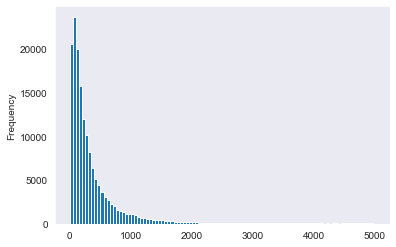

In [37]:
toxic_train['length'].plot(bins=100, kind='hist') 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x135ba56d0>,
      dtype=object)

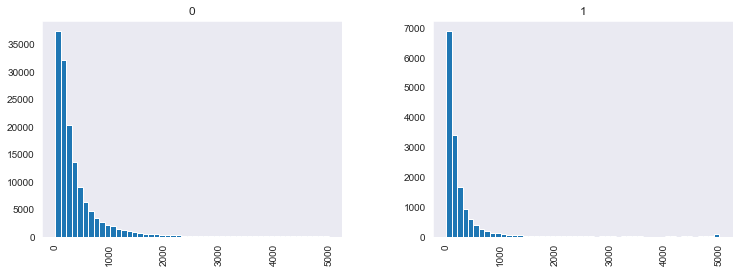

In [51]:
toxic_train.hist(column='length', by='toxic', bins=50,figsize=(12,4))

Length doesn't seem to have a lot of effect in determining the toxicity

## Creating WordCloud

In [32]:
stopword=set(STOPWORDS)
len(stopword)

192

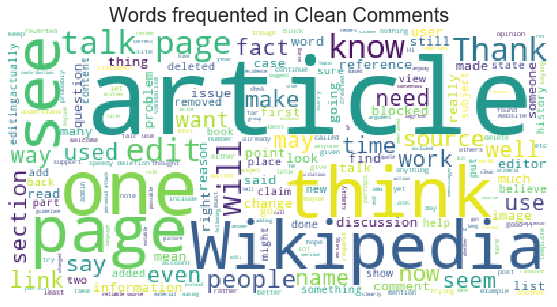

In [33]:
#wordcloud for clean comments
subset=toxic_train[toxic_train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,5))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

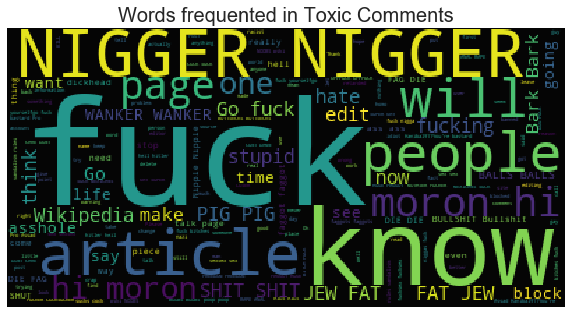

In [40]:
#wordcloud for toxic comments
subset=toxic_train[toxic_train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,5))
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

There is still few stopwords in this context like 'know', 'Wikipedia', 'will' that doesn't add much value. What we can do is search for common word in every comment and add them to the list of stopwords

## Begin text processing by removing punctuation and stopwords and use CountVectorizer

In [53]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopword]

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer=text_process).fit(toxic_train['comment_text'])

In [57]:
toxic_bow = bow_transformer.transform(toxic_train['comment_text'])

In [58]:
print('Shape of Sparse Matrix: ', toxic_bow.shape)
print('Amount of Non-Zero occurences: ', toxic_bow.nnz)

sparsity = (100.0 * toxic_bow.nnz / (toxic_bow.shape[0] * toxic_bow.shape[1]))
print('sparsity: {}'.format((sparsity)))

Shape of Sparse Matrix:  (159571, 301754)
Amount of Non-Zero occurences:  4514234
sparsity: 0.009375124957847524


## Calculate the TF-IDF

In [60]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(toxic_bow)

We'll go ahead and check what is the IDF (inverse document frequency) of the word `"fuck"` and of word `"wikipedia"`?

In [63]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['fuck']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['wikipedia']])

5.599371474446087
4.608545625342572


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [64]:
toxic_tfidf = tfidf_transformer.transform(toxic_bow)
type(toxic_tfidf)
print(toxic_tfidf.shape)
print(toxic_tfidf[0])

(159571, 301754)
  (0, 290975)	0.1880012187354604
  (0, 289313)	0.20085336741439344
  (0, 287792)	0.2598469418987354
  (0, 287174)	0.15966746919425645
  (0, 278177)	0.14585557830391963
  (0, 276234)	0.08535491628084235
  (0, 261165)	0.13414894890728044
  (0, 260930)	0.21169855664388626
  (0, 259534)	0.12480156374851353
  (0, 249831)	0.101146121994622
  (0, 245825)	0.07557155664058224
  (0, 241735)	0.33330707974703827
  (0, 230740)	0.10835860696671161
  (0, 194820)	0.11124008150647555
  (0, 192712)	0.08597123866419908
  (0, 179534)	0.2376489822214896
  (0, 158122)	0.17653717814399594
  (0, 100443)	0.14461272037200346
  (0, 94281)	0.2722372348102365
  (0, 73298)	0.094188330783543
  (0, 67955)	0.2589574661779316
  (0, 61140)	0.24945767229283433
  (0, 57219)	0.2372529667349742
  (0, 55841)	0.20447561729191813
  (0, 55561)	0.2589574661779316
  (0, 49936)	0.28253149003161165


There are many ways the data can be preprocessed and vectorized. These steps involve feature engineering and building a "pipeline". I encourage you to check out SciKit Learn's documentation on dealing with text data as well as the expansive collection of available papers and books on the general topic of NLP.

# Training a model

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [69]:
from sklearn.naive_bayes import MultinomialNB

toxic_naive = MultinomialNB().fit(toxic_tfidf, toxic_train['toxic'])

Let's try classifying our single random message and checking how we do:

In [ ]:
toxic_

## Model Evaluation

We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification). Check out the links for more detailed info on each of these metrics and the figure below:

In [56]:
from sklearn.metrics import classification_report
print (classification_report(messages['label'], all_predictions))

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      4825
       spam       1.00      0.85      0.92       747

avg / total       0.98      0.98      0.98      5572



## Train Test Split

In [57]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572



## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [58]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [59]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x11e795bf8>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [60]:
predictions = pipeline.predict(X_test)

In [61]:
print(classification_report(predictions,y_test))

             precision    recall  f1-score   support

        ham       1.00      0.96      0.98      1001
       spam       0.75      1.00      0.85       114

avg / total       0.97      0.97      0.97      1115

